In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

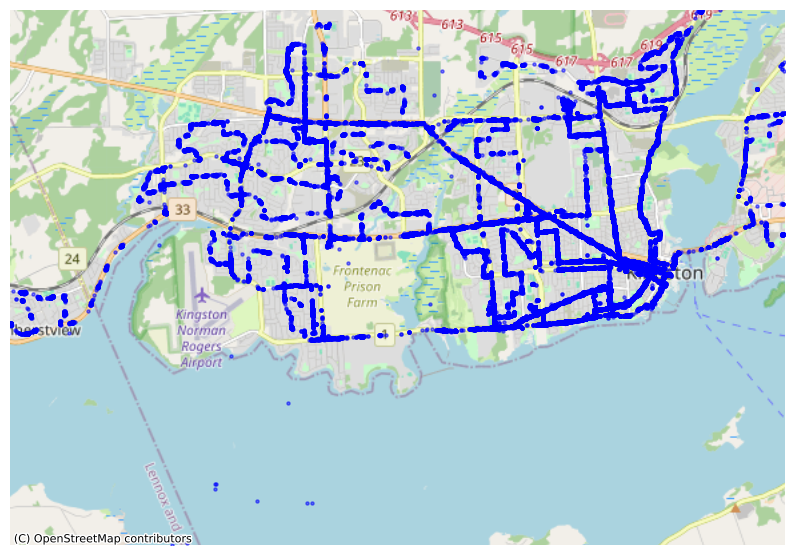

In [4]:
file_path = 'TransitData.csv'
data = pd.read_csv(file_path)
data = data[(data['Latitude'] != 0) & (data['Longitude'] != 0)]
lat_min, lat_max = 44.180, 44.300
lon_min, lon_max = -76.650, -76.450

# Filter out coordinates outside of Kingston
data = data[(data['Latitude'] >= lat_min) & (data['Latitude'] <= lat_max) & 
            (data['Longitude'] >= lon_min) & (data['Longitude'] <= lon_max)]

# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.Longitude, data.Latitude))
gdf.crs = 'EPSG:4326'  # Set coordinate reference system to WGS 84

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf.to_crs(epsg=3857).plot(ax=ax, color='blue', markersize=5, alpha=0.5)  # Convert to Web Mercator

# Define the map boundaries for Kingston, Ontario
xlim = ([min(gdf.to_crs(epsg=3857).geometry.x),
         max(gdf.to_crs(epsg=3857).geometry.x)])
ylim = ([min(gdf.to_crs(epsg=3857).geometry.y),
         max(gdf.to_crs(epsg=3857).geometry.y)])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)  # Add map basemap
ax.set_axis_off()
plt.show()

In [8]:
bus_stops_df = pd.read_csv('civic-addresses.csv')  # Adjust the path to your file
addresses_df = pd.read_csv('transit-gtfs-stops.csv')  # Adjust the path as needed

print("Bus Stops DataFrame columns:", bus_stops_df.columns)
print("Addresses DataFrame columns:", addresses_df.columns)

Bus Stops DataFrame columns: Index(['ADDRESS_NUMBER', 'STREET_BODY_NAME', 'STREET_TYPE_SUFFIX',
       'DIRECTION_SUFFIX', 'ADDRESS_NUMBER_SUFFIX', '﻿"MUNICIPALITY"',
       'UNIT_TYPE', 'UNIT', 'STREET', 'FULL_ADDRESS', 'GARBAGE_DAY',
       'ELECTORAL_DISTRICT_NAME', 'NEIGHBOURHOOD', 'RECYCLING_DAY',
       'POSTAL_CODE', 'ADDRESS_ID', 'GeoJSON', 'LongLat'],
      dtype='object')
Addresses DataFrame columns: Index(['ID', 'Name', 'LongLat'], dtype='object')


In [11]:
file_path_houses = 'civic-addresses.csv'  
file_path_bus_stops = 'TransitData.csv'   


import pandas as pd
from geopy.distance import geodesic

# Load the CSV files
bus_stops_df = pd.read_csv('TransitData.csv')  # Adjust the path to your file
addresses_df = pd.read_csv('civic-addresses.csv')  # Adjust the path as needed

# For addresses_df, split the "long lat" column into two separate columns
addresses_df[['Longitude', 'Latitude']] = addresses_df['long lat'].str.split(',', expand=True)

# Convert the new Longitude and Latitude columns to numeric for both DataFrames
addresses_df['Longitude'] = pd.to_numeric(addresses_df['Longitude'], errors='coerce')
addresses_df['Latitude'] = pd.to_numeric(addresses_df['Latitude'], errors='coerce')
bus_stops_df['Longitude'] = pd.to_numeric(bus_stops_df['Longitude'], errors='coerce')
bus_stops_df['Latitude'] = pd.to_numeric(bus_stops_df['Latitude'], errors='coerce')

# Define the geographical boundaries for Kingston
lat_min, lat_max = 44.180, 44.300
lon_min, lon_max = -76.650, -76.450

# Filter out coordinates outside of Kingston and coordinates set to 0 for addresses_df
addresses_df = addresses_df[(addresses_df['Latitude'] != 0) & (addresses_df['Longitude'] != 0) &
                            (addresses_df['Latitude'] >= lat_min) & (addresses_df['Latitude'] <= lat_max) & 
                            (addresses_df['Longitude'] >= lon_min) & (addresses_df['Longitude'] <= lon_max)]

# Repeat the filtering for bus_stops_df
bus_stops_df = bus_stops_df[(bus_stops_df['Latitude'] != 0) & (bus_stops_df['Longitude'] != 0) &
                            (bus_stops_df['Latitude'] >= lat_min) & (bus_stops_df['Latitude'] <= lat_max) & 
                            (bus_stops_df['Longitude'] >= lon_min) & (bus_stops_df['Longitude'] <= lon_max)]

# Define a function to find redundant bus stops based on a threshold distance
def find_redundant_bus_stops(df, threshold=0.1):  # Threshold in kilometers
    redundant_pairs = []
    for i, stop1 in df.iterrows():
        for j, stop2 in df.iterrows():
            if i < j:  # Avoid repeating comparisons
                distance = geodesic((stop1['Latitude'], stop1['Longitude']), (stop2['Latitude'], stop2['Longitude'])).kilometers
                if distance <= threshold:
                    redundant_pairs.append((i, j))
    return redundant_pairs

# Find redundant bus stops
redundant_bus_stops = find_redundant_bus_stops(bus_stops_df)

# Print or save the redundant bus stops
print("Redundant Bus Stops (by index):", redundant_bus_stops)



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/geopy/point.py:472: UserWarning: Latitude normalization has been prohibited in the newer versions of geopy, because the normalized value happened to be on a different pole, which is probably not what was meant. If you pass coordinates as positional args, please make sure that the order is (latitude, longitude) or (y, x) in Cartesian terms.
  return cls(*args)


ValueError: Latitude must be in the [-90; 90] range.